<h1 style="text-align:center;">
Topic Modelling
</h1> 
Identify Topics in the Harry Potter Book reviews to later identify the users likes and dislikes

### Table Of Contents:
* [Imports and Data](#1)
* [Text Preprocessing](#2)
* [Sentiment Label](#3)
* [Topic Modelling](#4)
* [The Topics](#5)
* [References](#6)

## **1** Imports and Read in Data <a class="anchor" id="1"></a>

In [32]:
# Install Libraries (uncomment if not downloaded)
# !pip install pandas nltk gensim pyLDAvis

In [34]:
# nltk.download('stopwords')
# nltk.download('wordnet')

In [36]:
# Import Libraries
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models

import string
import re

In [37]:
# Read in the data
data = r'data/analysis_tokenised_newwords.csv'
df=pd.read_csv(data)

# Fill in the null reviews
df.review = df.review.fillna('')

## **2** Text Preprocessing <a class="anchor" id="2"></a>

In [41]:
# Create set with stopwords and a set with puctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# lemmatiser and stemmer
lemmatizer = WordNetLemmatizer()
p_stemmer = PorterStemmer()

def preprocess(text):
    ''' preprocessies the text'''
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text) ## to filter out non-english stuff and numbers
    tokens = nltk.word_tokenize(text) # tokenise
    tokens = [word for word in tokens if word not in stop_words and word not in punctuation and word.isalpha()]
    #tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
    tokens = [p_stemmer.stem(word) for word in tokens] # stem
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

# Apply to each review and store in seperate columns
df['processed'] = df['review'].apply(preprocess)


In [42]:
# Have a look
df.head()

,book,rating,review,images,likes,comments,tokens,token_neg,token_neu,token_pos,token_compound,token_avg_neg,token_avg_neu,token_avg_pos,token_avg_compound,processed
0,Harry Potter and the Philosopher’s Stone,1,This is a disgrace to all pure bloods. My head...,0,9254,33,"['This is a disgrace to all pure bloods.', ""My...","[0.348, 0.167, 0.0, 0.0, 0.0]","[0.652, 0.833, 1.0, 0.222, 1.0]","[0.0, 0.0, 0.0, 0.778, 0.0]","[-0.4939, -0.2023, 0.0, 0.5423, 0.0]",0.103000,0.741400,0.155600,-0.030780,"[disgrac, pure, blood, head, look, quit, dash,..."
1,Harry Potter and the Philosopher’s Stone,1,Can 35 Million Book Buyers Be Wrong? Yes.Takin...,0,421,4,"['Can 35 Million Book Buyers Be Wrong?', 'Yes....","[0.341, 0.133, 0.0, 0.033, 0.0, 0.0, 0.0, 0.23...","[0.659, 0.711, 1.0, 0.864, 0.909, 0.906, 0.749...","[0.0, 0.156, 0.0, 0.104, 0.091, 0.094, 0.251, ...","[-0.4767, 0.128, 0.0, 0.5719, 0.4215, 0.4497, ...",0.039542,0.861000,0.099458,0.284737,"[million, book, buyer, wrong, yestak, arm, har..."
2,Harry Potter and the Philosopher’s Stone,1,We don't support transphobes in this house,0,340,19,"[""We don't support transphobes in this house""]",[0.273],[0.727],[0.0],[-0.3089],0.273000,0.727000,0.000000,-0.308900,"[dont, support, transphob, hous]"
3,Harry Potter and the Philosopher’s Stone,1,Update: 23/8/2018 My review is still hidden fr...,1,237,4,['Update: 23/8/2018 My review is still hidden ...,"[0.0, 0.0, 0.0, 0.236, 0.12, 0.26, 0.0, 0.0, 0...","[1.0, 1.0, 1.0, 0.764, 0.757, 0.74, 0.843, 0.7...","[0.0, 0.0, 0.0, 0.0, 0.124, 0.0, 0.157, 0.284,...","[0.0, 0.0, 0.0, -0.5719, 0.0258, -0.2755, 0.42...",0.045286,0.871381,0.083333,0.145895,"[updat, review, still, hidden, view, gr, list,..."
4,Harry Potter and the Philosopher’s Stone,1,Pathetic. Really pathetic.Harry Potter is more...,0,200,4,"['Pathetic.', 'Really pathetic.Harry Potter is...","[1.0, 0.0, 0.0, 0.163, 0.392, 0.0, 0.104, 0.10...","[0.0, 1.0, 1.0, 0.598, 0.608, 1.0, 0.734, 0.70...","[0.0, 0.0, 0.0, 0.239, 0.0, 0.0, 0.162, 0.191,...","[-0.5719, 0.0, 0.0, 0.2585, -0.7964, 0.0, 0.36...",0.152190,0.743000,0.104857,0.065910,"[pathet, realli, patheticharri, potter, marysu..."


## **3** Sentiment Label <a class="anchor" id="3"></a>

In [44]:
def sentiment_label(compound_sentiment):
    '''labels the sentiment scores ---> looks at the compund score'''
    
    if compound_sentiment >= 0.05:
        return 'Positive'
    elif compound_sentiment <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [45]:
# Apply and store in seperate column
df['sentiment_label'] = df['token_avg_compound'].apply(sentiment_label)

## **4** Topic Modelling <a class="anchor" id="4"></a>

### **4.1** LDA
Starting off with 5 topics

In [48]:
# Prepare data for LDA
dictionary = corpora.Dictionary(df['processed'])
corpus = [dictionary.doc2bow(text) for text in df['processed']]

In [49]:
# Build LDA Model
lda_model = LdaModel(corpus, 
                     num_topics=5, 
                     id2word=dictionary, 
                     passes=10)

### **4.2** Visualize Topics
Use pyLDAvis to visualise the topic modelling
> Note: uses a lot of computing power

In [51]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

**Salience and Relevance Explanation:**

<u> Salience </u>: It helps identify the words that are most informative to identify topics within documents. A higher salience value indicates that a word is more useful in identifying a specific topic.

<u> Topic Relevance </u>: It orders words within topics to help identify the most appropriate words for each topic. Higher relevance means the word is more important for that topic.

**Implementing Salience and Topic Relevance:**

You will be able to visualize salience and topic relevance using pyLDAvis. pyLDAvis provides an interactive way to explore the topics, including understanding the relevance of words within topics and their salience.

From: ChatGPT

In [53]:
# Cohereance Score of LDA Model
coherence_model_lda = CoherenceModel(model=lda_model, 
                                         texts=df['processed'], 
                                         dictionary=dictionary, 
                                         coherence='c_v')
print(coherence_model_lda.get_coherence())

0.443782058179636


> Coherence Score tells us how interpretable the topics are. We want to optimise this.

### **4.3** Optimise Values

> NOTE: The following cell take a **long time** to run!!


> NOTE: Produces different results when rerun

In [56]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    '''Function that runs through different number of topics and gives coherence score for each'''
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus, 
                         num_topics=num_topics, 
                         id2word=dictionary, 
                         passes=10)
        model_list.append(model)
        coherence_model_lda = CoherenceModel(model=model, 
                                             texts=texts, 
                                             dictionary=dictionary, 
                                             coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())
    return model_list, coherence_values

# Apply Function
model_list, coherence_values = compute_coherence_values(dictionary, 
                                                        corpus, 
                                                        df['processed'], 
                                                        limit=40, 
                                                        start=2, 
                                                        step=3)


In [57]:
# What does the modellist look like?
model_list

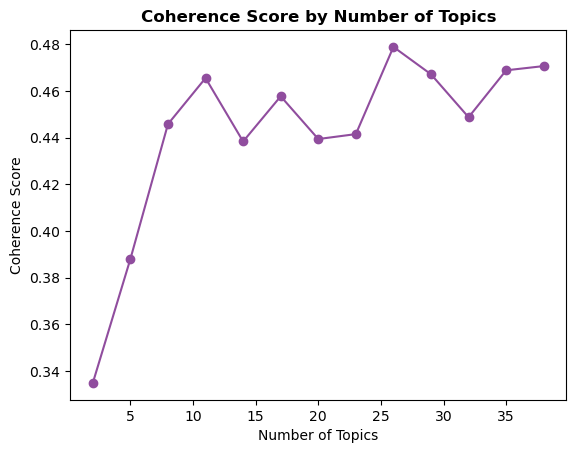

In [58]:
# Visualise the best number of topics
import matplotlib.pyplot as plt

limit=40 
start=2
step=3

x = range(start, limit, step)
plt.plot(x, 
         coherence_values, 
         marker='o',
        color = '#904d9e'
        )
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score by Number of Topics", fontweight = 'bold')
plt.savefig(r'plots/coherance.png', transparent = True)
plt.show()

In [59]:
# Choose the model with highest coherence value
optimal_model = model_list[coherence_values.index(max(coherence_values))]

In [60]:
# What does this look like
optimal_model

In [61]:
# Visualise The optimal
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, dictionary)
pyLDAvis.display(vis)

In [62]:
# Print out the coherence score of the optimal model
coherence_model_optimal = CoherenceModel(model=optimal_model, 
                                         texts=df['processed'], 
                                         dictionary=dictionary, 
                                         coherence='c_v')
coherence_score = coherence_model_optimal.get_coherence()
print(f'Coherence Score: {coherence_score}')

Coherence Score: 0.47881411561464876


## **5** The Topics <a class="anchor" id="5"></a>


### **5.1** Inspect the Topics

In [65]:
# Inspect topics
topics = optimal_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(11, '0.026*"tran" + 0.019*"support" + 0.016*"peopl" + 0.015*"terf" + 0.012*"dont" + 0.010*"artist" + 0.010*"aww" + 0.009*"dot" + 0.008*"jkr" + 0.007*"hp"')
(17, '0.023*"book" + 0.016*"like" + 0.011*"charact" + 0.010*"harri" + 0.009*"get" + 0.008*"one" + 0.008*"thing" + 0.008*"would" + 0.007*"think" + 0.007*"realli"')
(6, '0.041*"harri" + 0.013*"ron" + 0.013*"hermion" + 0.012*"love" + 0.011*"dumbledor" + 0.010*"snape" + 0.009*"one" + 0.008*"death" + 0.007*"like" + 0.007*"voldemort"')
(13, '0.073*"review" + 0.066*"star" + 0.046*"illustr" + 0.026*"rate" + 0.024*"edit" + 0.021*"goodread" + 0.013*"blog" + 0.011*"read" + 0.008*"oneth" + 0.007*"author"')
(7, '0.009*"jan" + 0.008*"underton" + 0.007*"tha" + 0.006*"bigot" + 0.004*"virgin" + 0.003*"text" + 0.003*"jkr" + 0.003*"show" + 0.003*"fuckin" + 0.003*"dnfd"')
(23, '0.015*"tome" + 0.014*"drown" + 0.008*"stark" + 0.007*"cure" + 0.007*"kudo" + 0.007*"moreit" + 0.004*"bbc" + 0.004*"etsi" + 0.004*"renam" + 0.004*"starsread"')
(14, '0.008*"favo

In [66]:
# Store topics for each review in table
df['topic'] = [optimal_model.get_document_topics(bow) for bow in corpus]

# Function to get the dominant topic for each document
def get_dominant_topic(doc_topics):
    dominant_topic = max(doc_topics, key=lambda x: x[1])
    return dominant_topic[0]

# Store the dominant topic for each review
df['dominant_topic'] = df['topic'].apply(get_dominant_topic)

# Group by dominant topic and sentiment label to see the distribution
sentiment_topic_distribution = df.groupby(['dominant_topic', 'sentiment_label']).size().unstack()
sentiment_topic_distribution

sentiment_label,Negative,Neutral,Positive
dominant_topic,,,
0,2.0,29.0,NaN
1,8.0,1.0,7.0
2,16.0,26.0,35.0
3,9.0,5.0,5.0
4,3.0,2.0,NaN
5,NaN,6.0,1.0
6,119.0,74.0,408.0
7,NaN,6.0,NaN
8,9.0,6.0,6.0


In [67]:
df['topic']

0       [(2, 0.15447979), (6, 0.41674328), (17, 0.2108...
1       [(6, 0.016516494), (9, 0.4777757), (17, 0.2354...
2                    [(11, 0.45026252), (18, 0.36511403)]
3       [(2, 0.02911536), (9, 0.21061607), (11, 0.0210...
4       [(17, 0.79278487), (22, 0.06379038), (25, 0.13...
                              ...                        
6295    [(6, 0.9457656), (17, 0.027423594), (19, 0.018...
6296    [(6, 0.26493153), (9, 0.08611239), (22, 0.3383...
6297    [(3, 0.032412816), (6, 0.24797188), (17, 0.098...
6298    [(6, 0.18076468), (9, 0.14193557), (17, 0.1986...
6299                  [(9, 0.17219122), (22, 0.81654924)]
Name: topic, Length: 6300, dtype: object

### **5.2** Topic WordClouds
Visualise what words make up a topic by making WordClouds

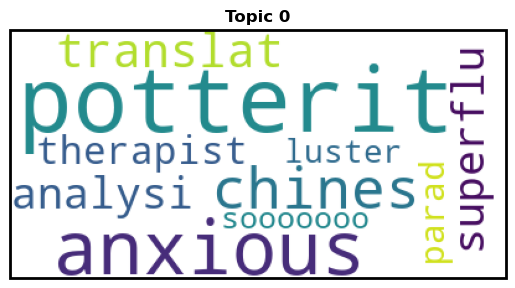

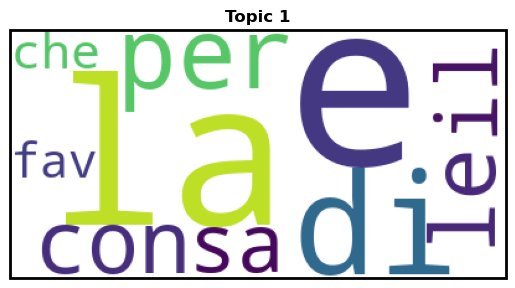

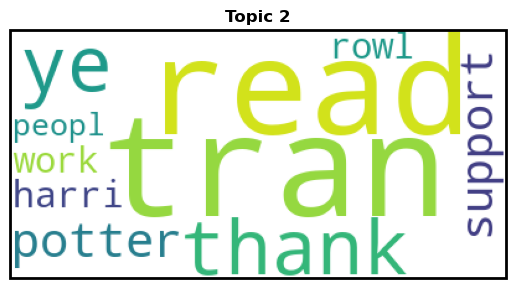

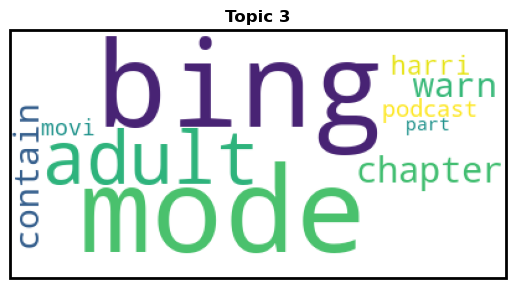

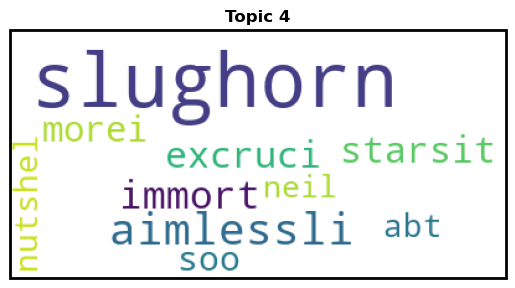

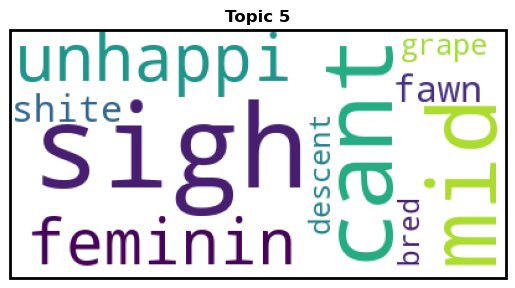

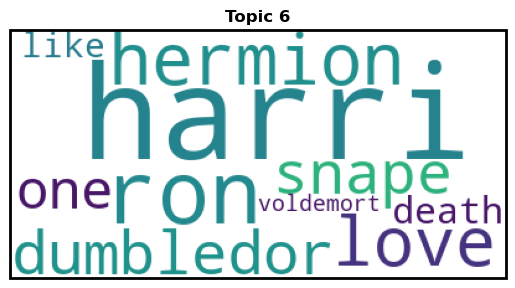

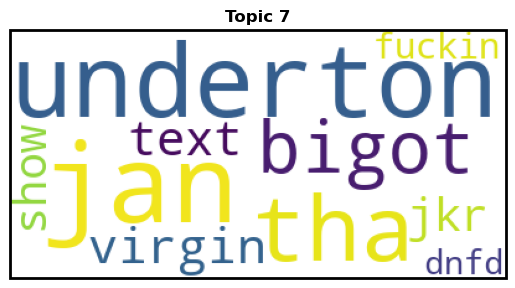

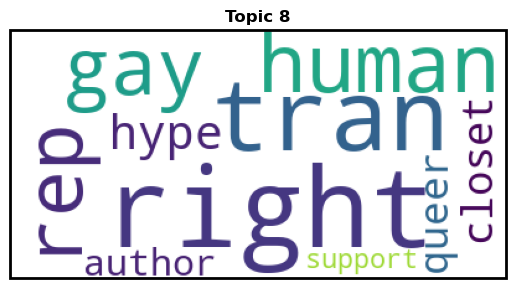

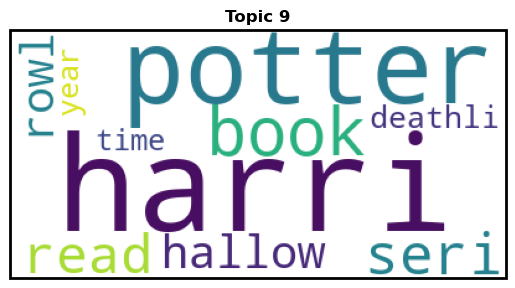

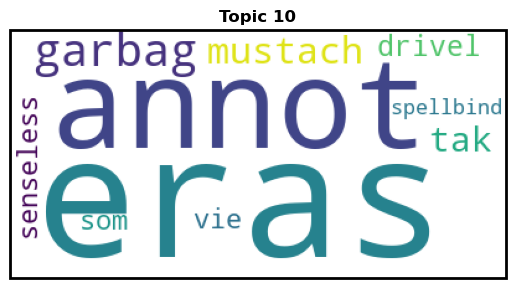

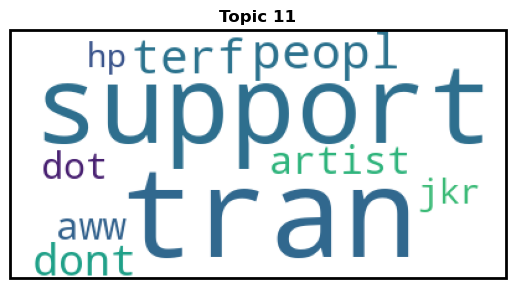

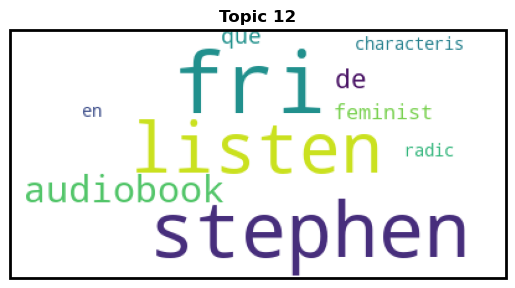

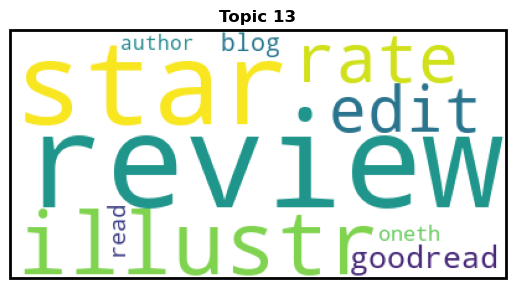

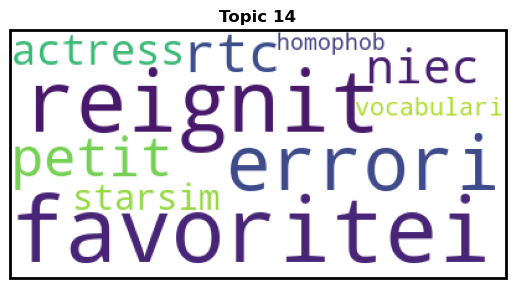

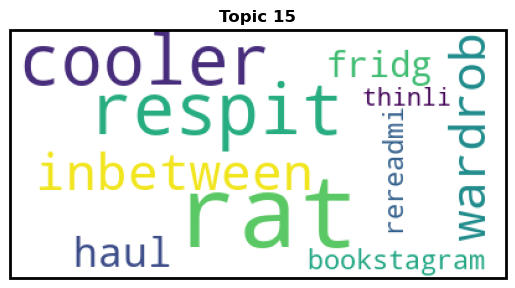

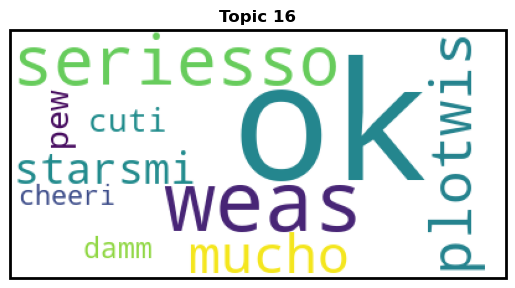

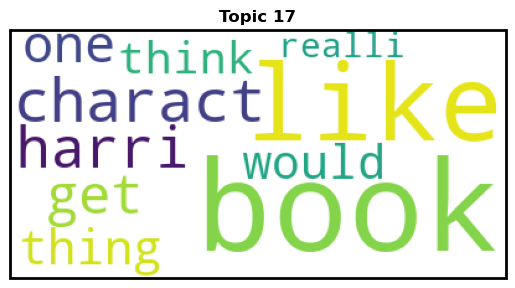

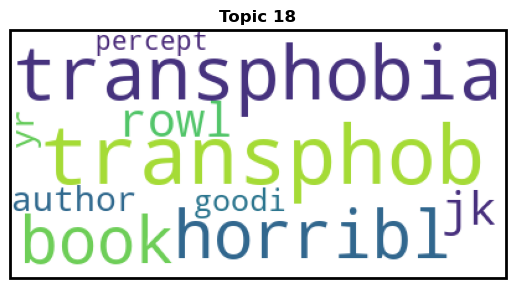

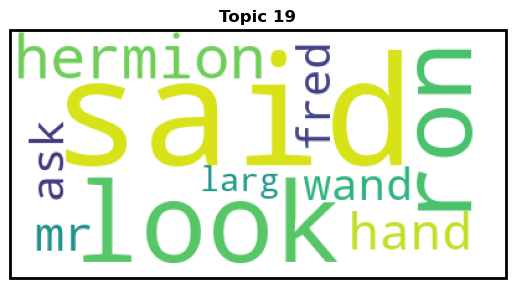

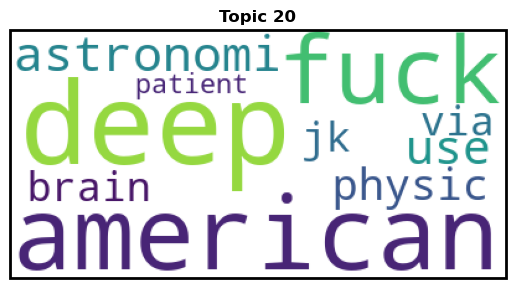

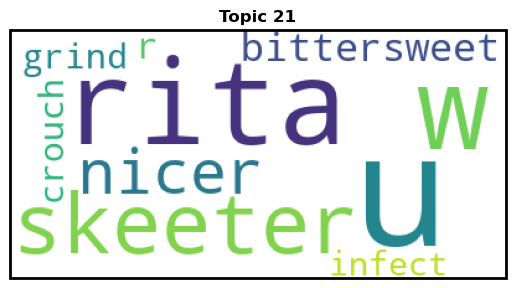

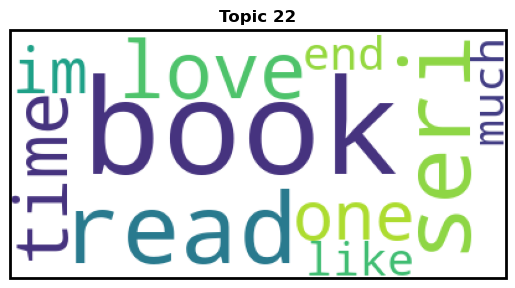

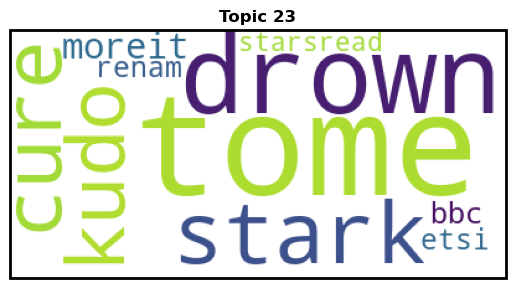

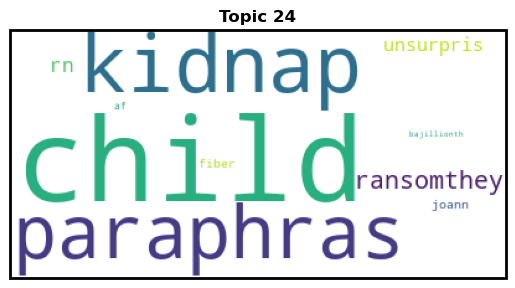

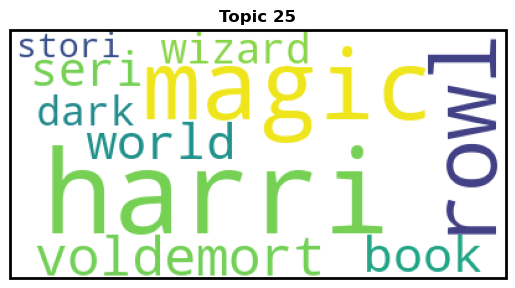

In [69]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from collections import Counter

# Function to generate word clouds for each topic
def plot_word_cloud(lda_model, num_topics, num_words=10):
    for t in range(num_topics):
        
        plt.figure()
        plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_model.show_topic(t, num_words))))
        plt.axis('off')
        
         # Add a border
        ax = plt.gca()
        rect = Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='black', facecolor='none', transform=ax.transAxes, clip_on=False)
        ax.add_patch(rect)
        
        plt.title(f'Topic {t}', fontweight = 'bold')
        
        plt.savefig(f'wordclouds/wordcloud_topic_{t}.png', bbox_inches='tight', transparent=True)
        
        plt.show()

# Assume optimal_model is your final LDA model and it has 'num_topics' topics
num_topics = optimal_model.num_topics
plot_word_cloud(optimal_model, num_topics)

## **6** References <a class="anchor" id="3"></a>
* https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0